In [29]:
library(CellChat)
library(tidyverse)
library(Seurat)

In [30]:
setwd('/import/DB/fel/BJTC-204')

In [32]:
sce = readRDS('male.sc.rds')

In [35]:
sce$celltype = factor(sce$celltype,levels = c('Ast','ExN','InN','OPC','Oli','End','Mic'))

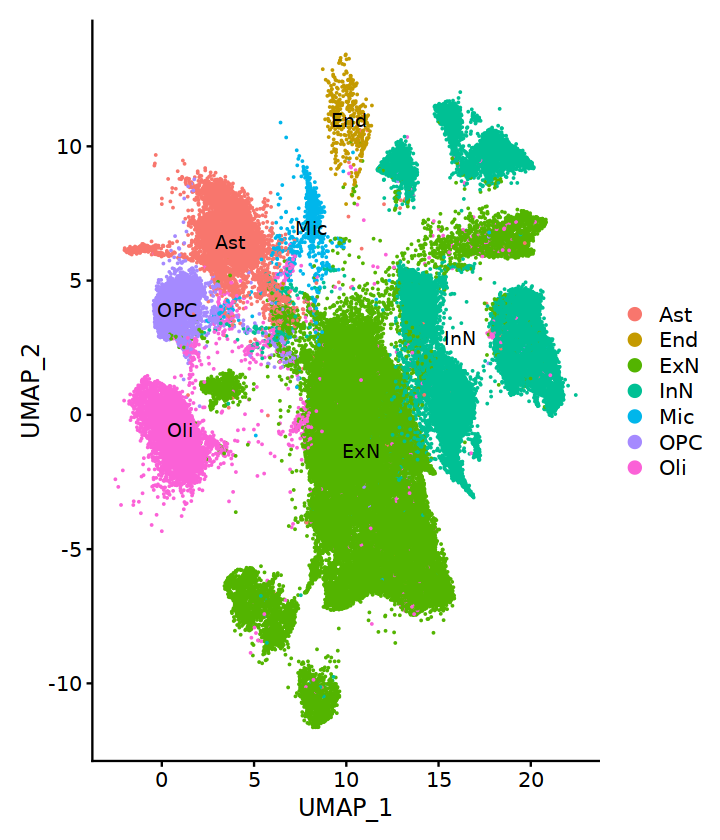

In [37]:
DimPlot(sce,label = T)

In [38]:
Idents(sce) = 'celltype'
DefaultAssay(sce) = 'RNA'
sce.markers <- FindAllMarkers(object = sce, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)

Calculating cluster Ast

Calculating cluster ExN

Calculating cluster InN

Calculating cluster OPC

Calculating cluster Oli

Calculating cluster End

Calculating cluster Mic



In [55]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(6, avg_log2FC)

In [56]:
scRNA = sce

In [57]:
gene_cell_exp <- AverageExpression(scRNA,
                                   features = unique(top5$gene),
                                   group.by = 'celltype',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [58]:
colnames(gene_cell_exp)

[1] "Ast" "ExN" "InN" "OPC" "Oli" "End" "Mic"

In [59]:
gene_cell_exp = gene_cell_exp[,c('Ast','ExN','InN','OPC','Oli','End','Mic')]

In [60]:
library(ComplexHeatmap)
#顶部细胞类型注释
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'

In [61]:
df$class = factor(df$class,levels =c('Ast','ExN','InN','OPC','Oli','End','Mic'))

In [62]:
top_anno = HeatmapAnnotation(df = df,#细胞名/cluster
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c('Ast' = '#A0CCFF','ExN'="#2F528F",
                                                  "InN"="#E3AD68",'OPC'='#84CAC0','Oli'='#F5AE6B','End'='#BCB8D3',
                                                 'Mic'='#4387B5')))#颜色设置

In [63]:
#数据标准化缩放一下
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

In [64]:
options(repr.plot.height = 8,repr.plot.width = 6)

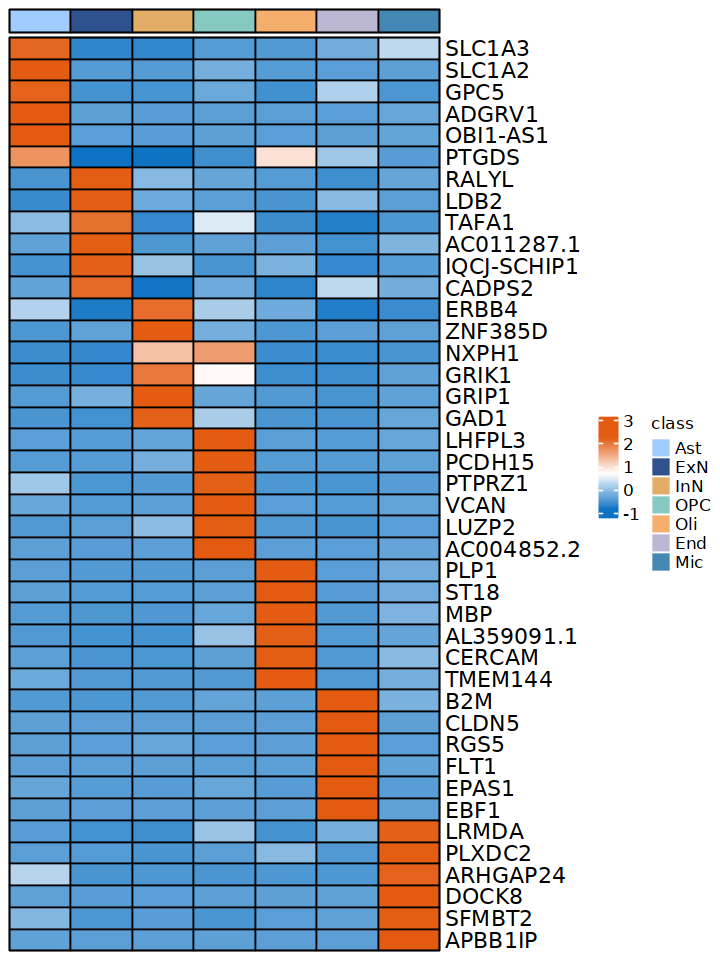

In [65]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)

In [66]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)
Idents(scRNA) <- "celltype" 
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)
# library(msigdbr)
# msigdbr_species() #列出有的物种

Warning message:
"package 'GSVA' was built under R version 4.2.3"
Loading required package: AnnotationDbi

Warning message:
"package 'AnnotationDbi' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: IRanges

Warning message:
"package 'IRanges' was built under R version 4.2.3"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.3"

Attaching package: 'S4Vectors'


The following objects are masked from 'package:lubridate':

    second, second<-


The following object is masked from 'package:tidyr':

    expand


The following objects are masked from 'package:dplyr':

    first, rename


The following objects are masked from 'package:base':

    I, expand.grid, unname



Attaching package: 'IRanges'


The following object is masked from 'package:lubridate':

    %within%


The following object is masked from 'package:purrr':

    reduce


The following objects are masked from 'package:dplyr':



In [67]:
d = '/import/DB' 

In [69]:
gmtfs <- list.files(d,pattern = '.gmt')  # 路径下所有结尾为symbols.gmt文件
gmtfs

[1] "BP.gmt"                   "h.all.v7.5.1.symbols.gmt"
[3] "kegg.gmt"

In [71]:
library(GSEABase)

In [72]:
kegg_list <- getGmt(file.path(d,gmtfs[3])) 
go_list <- getGmt(file.path(d,gmtfs[1])) 
hall_list <- getGmt(file.path(d,gmtfs[2])) 

Warning message in getGmt(file.path(d, gmtfs[3])):
"28 record(s) contain duplicate ids: Alzheimer disease, Amyotrophic lateral sclerosis, ..., Spliceosome, Starch and sucrose metabolism"
Warning message in getGmt(file.path(d, gmtfs[1])):
"2 record(s) contain duplicate ids: GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT, GOBP_PROTEOLYSIS_INVOLVED_IN_PROTEIN_CATABOLIC_PROCESS"


In [79]:
human_KEGG_Set = go_list
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

dim(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(5) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('GOBP_','',rownames(gsva.kegg))
rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message in .gsva(expr, mapped.gset.idx.list, method, kcdf, rnaseq, abs.ranking, :
"Some gene sets have size one. Consider setting 'min.sz > 1'."


Estimating GSVA scores for 7643 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,Ast,ExN,InN,OPC,Oli,End,Mic
GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,-0.0420058,-0.1881136,0.13172847,0.40761998,-0.26365738,-0.4119037,0.20628795
GOBP_2FE_2S_CLUSTER_ASSEMBLY,-0.3078636,-0.4820310,0.16909301,-0.43529594,-0.22555107,0.5483903,-0.22190716
GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,0.5571189,-0.4548155,0.09644607,-0.21382029,0.07989124,-0.2464716,-0.13898507
GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS,-0.1333258,0.1417053,0.27101460,0.21421266,-0.49923129,0.2593331,-0.05729313
GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION,-0.2363483,-0.6619412,-0.45044681,0.01105348,0.07738911,0.3350617,0.50796929
GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION,-0.3728464,-0.3641077,-0.43646096,-0.27622136,-0.12059882,0.4517280,0.44105608


[1] 7643    7

In [86]:
options(repr.plot.width = 14,repr.plot.height = 8)

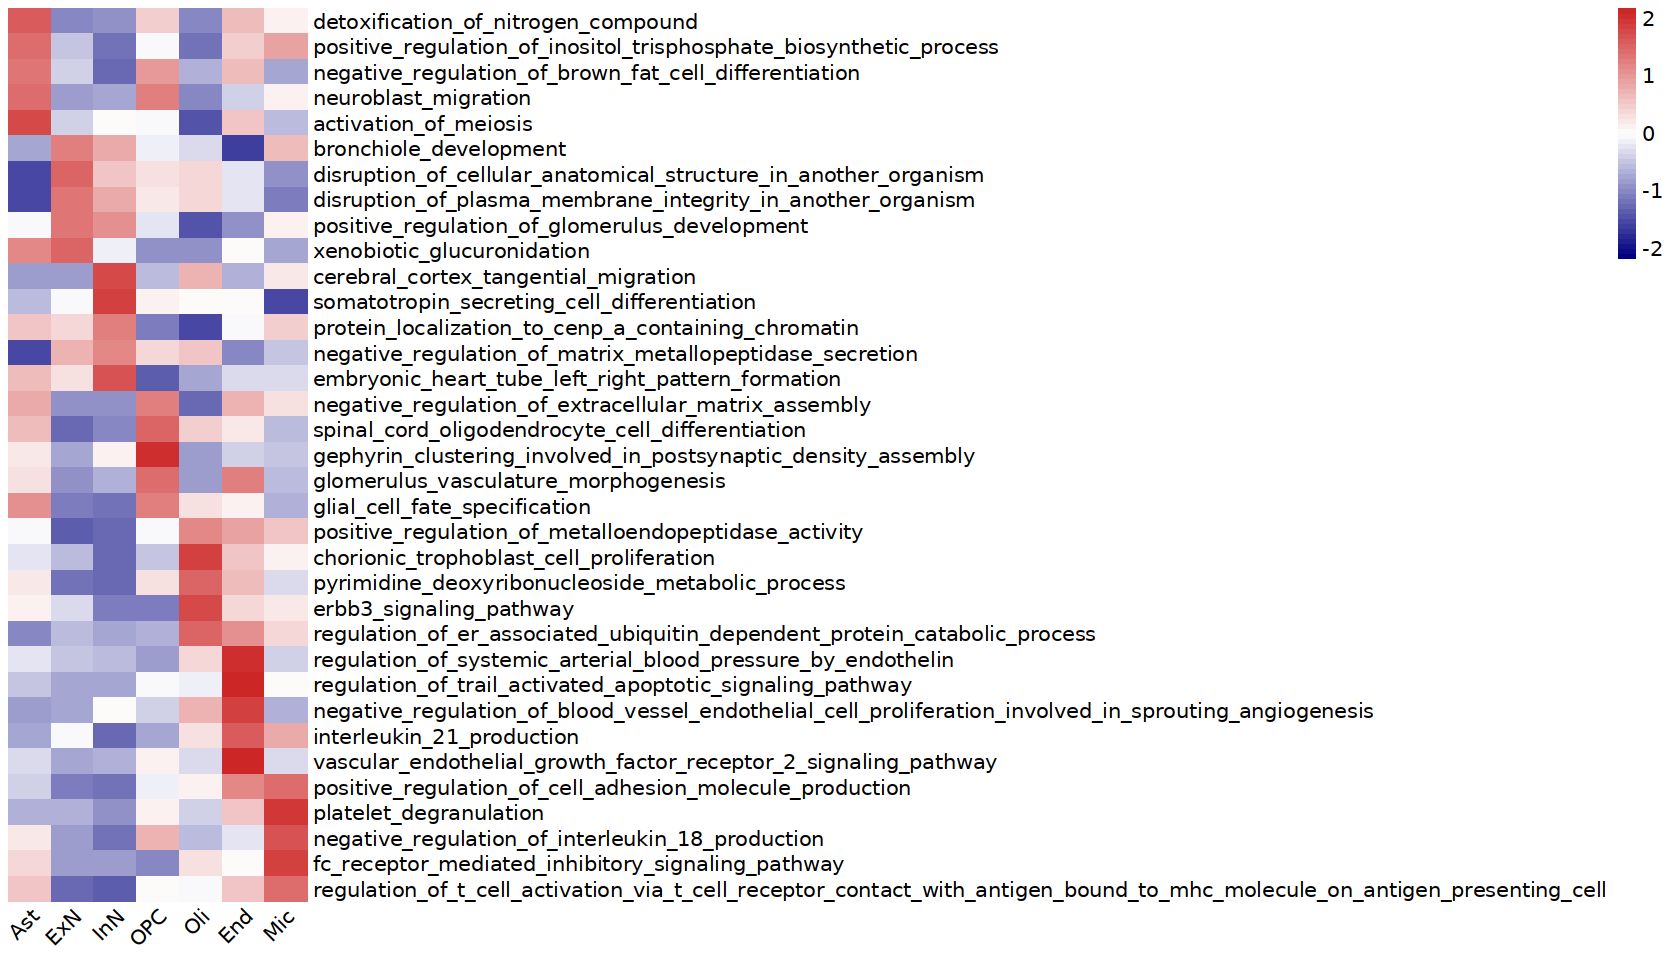

In [87]:
library(pheatmap)
p = pheatmap(gsva.kegg, scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,fontsize = 12,
        #      show_column_names = FALSE,
        # show_row_names = TRUE,
             color = colorRampPalette(c("navy", "white", "firebrick3"))(50))

### kegg

In [89]:
human_KEGG_Set = kegg_list
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

dim(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(5) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
#rownames(gsva.kegg) = gsub('GOBP_','',rownames(gsva.kegg))
#rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 346 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,Ast,ExN,InN,OPC,Oli,End,Mic
Glycolysis / Gluconeogenesis,0.16983495,-0.2818550,-0.05889967,-0.36391770,-0.2140274,0.32108939,0.06152707
Citrate cycle (TCA cycle),-0.12295563,-0.4476881,0.31767651,-0.68267623,-0.3057876,0.43648481,0.24255945
Pentose and glucuronate interconversions,0.03802982,-0.1234912,-0.12889470,0.06922217,0.3665668,0.03068221,-0.20049154
Fructose and mannose metabolism,0.25905918,-0.2303013,-0.35061038,-0.37601457,-0.1065604,0.12282398,0.12895685
Galactose metabolism,0.29429613,-0.3849245,-0.32513044,-0.24462851,-0.2375217,0.13128822,0.29049163
Ascorbate and aldarate metabolism,0.12675138,-0.3065928,-0.12822688,0.16655024,0.2598408,0.20785644,-0.09056654


[1] 346   7

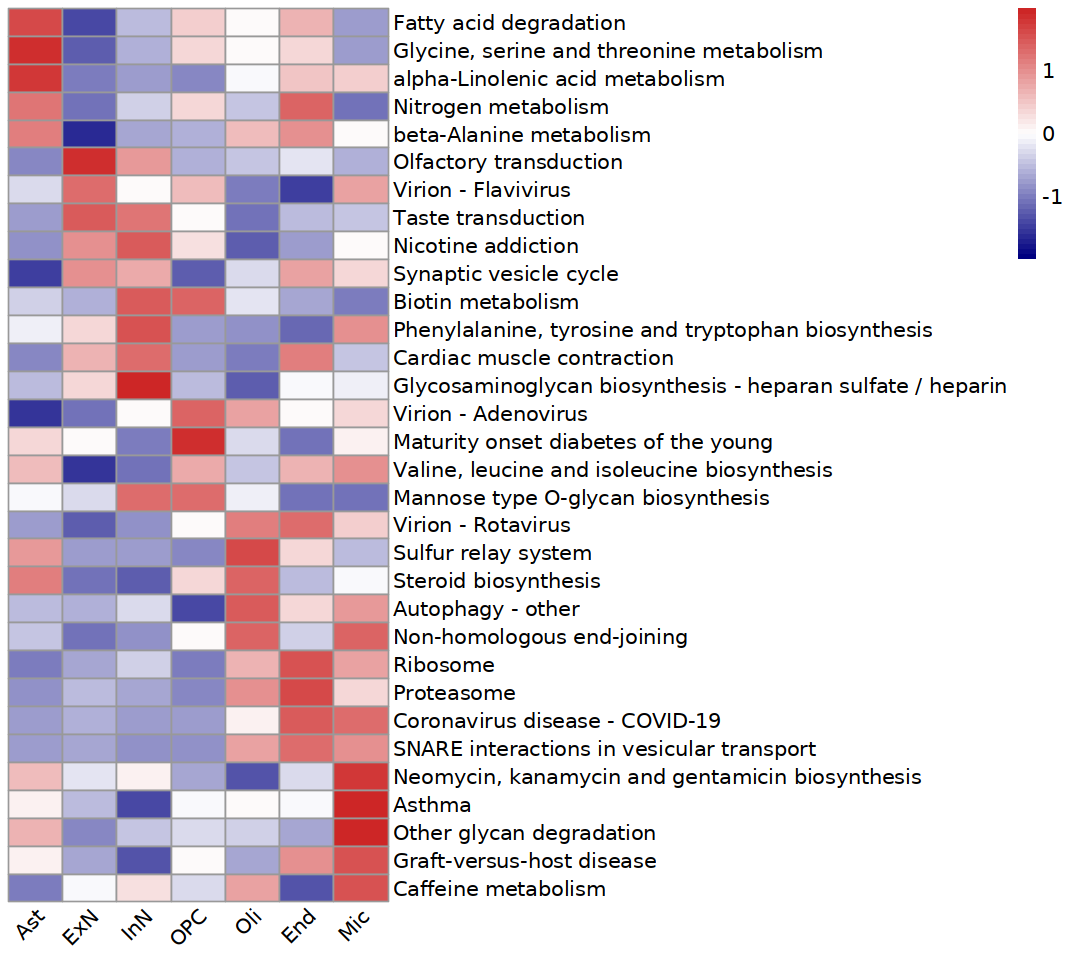

In [90]:
library(pheatmap)
p = pheatmap(gsva.kegg, scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,fontsize = 12,
        #      show_column_names = FALSE,
        # show_row_names = TRUE,
             color = colorRampPalette(c("navy", "white", "firebrick3"))(50))

In [92]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

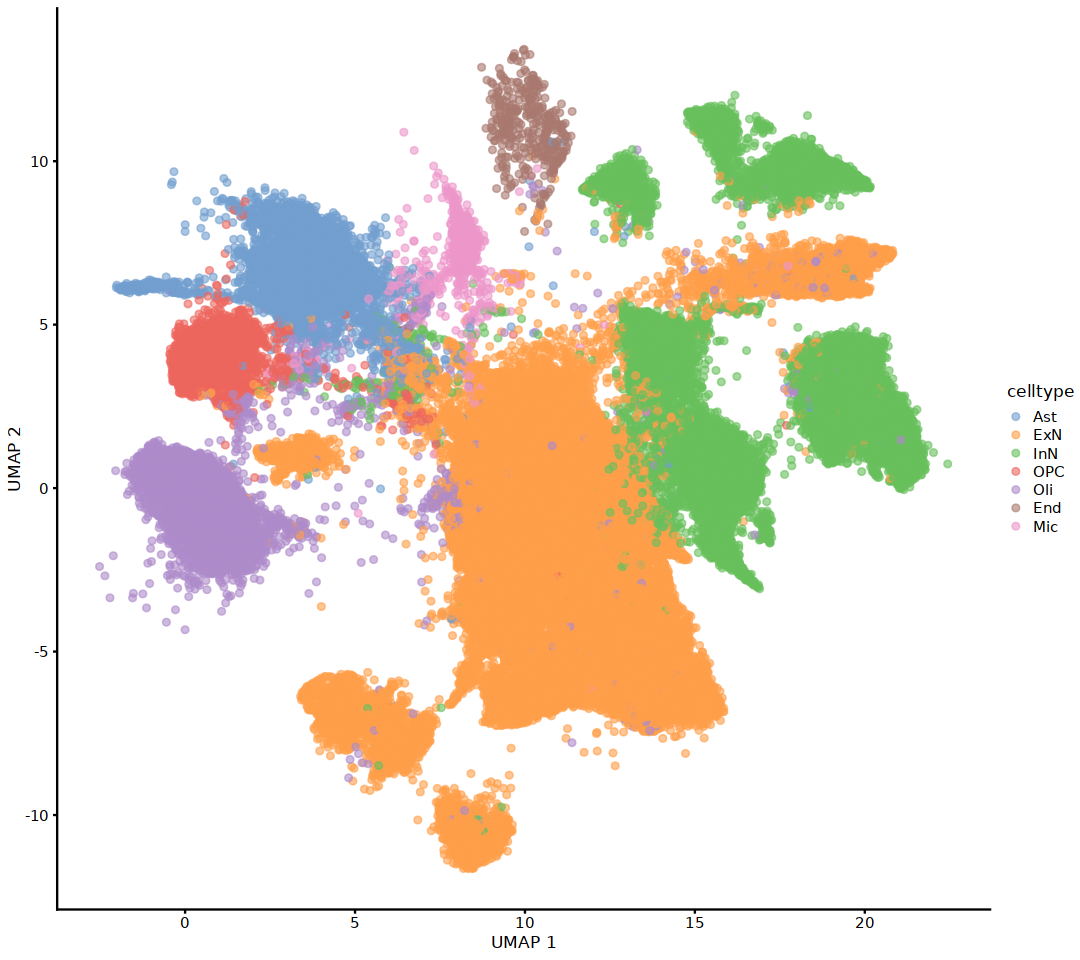

In [94]:
sce <- as.SingleCellExperiment(scRNA)
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

In [98]:
scRNA$sample = scRNA$orig.ident

In [99]:
table(scRNA$orig.ident)


   M1   M10   M11   M12   M13   M14   M15   M16   M17   M18   M19    M2   M20 
 2808  2516  3879  2045  2099  1830  3788  1269  3550  1555  2560  2013  4346 
  M21   M22   M23   M24 M24_2   M26   M27   M28   M29    M3   M30   M31   M32 
 2109  2097  4024   668   645  1931  1173  2370  2050  1362  2152  3293  2549 
  M33   M34    M4    M5    M6    M7    M8    M9 
 2355  3174  2413  1271  2655  2246  1882  1302 

In [ ]:
scmilo <- Milo(sce)
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "sample")
head(nhoodCounts(scmilo))

Computing PCA - name not in slot



In [ ]:
sc_design <- data.frame(colData(scmilo))[,c("sample", "group")]
sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$sample
sc_design <- sc_design[colnames(nhoodCounts(scmilo)), , drop=FALSE]
table(sc_design$group)

In [ ]:
rownames(sc_design) <- sc_design$sample

In [ ]:
sc_design

In [ ]:
model.gene = c('HIST1H4C','PRSS3','TUSC3')

DefaultAssay(sce) = 'RNA'

Idents(sce) = 'Condition'

options(repr.plot.width = 6)

DotPlot(sce,features = model.gene)

In [9]:
options(repr.plot.width = 8)

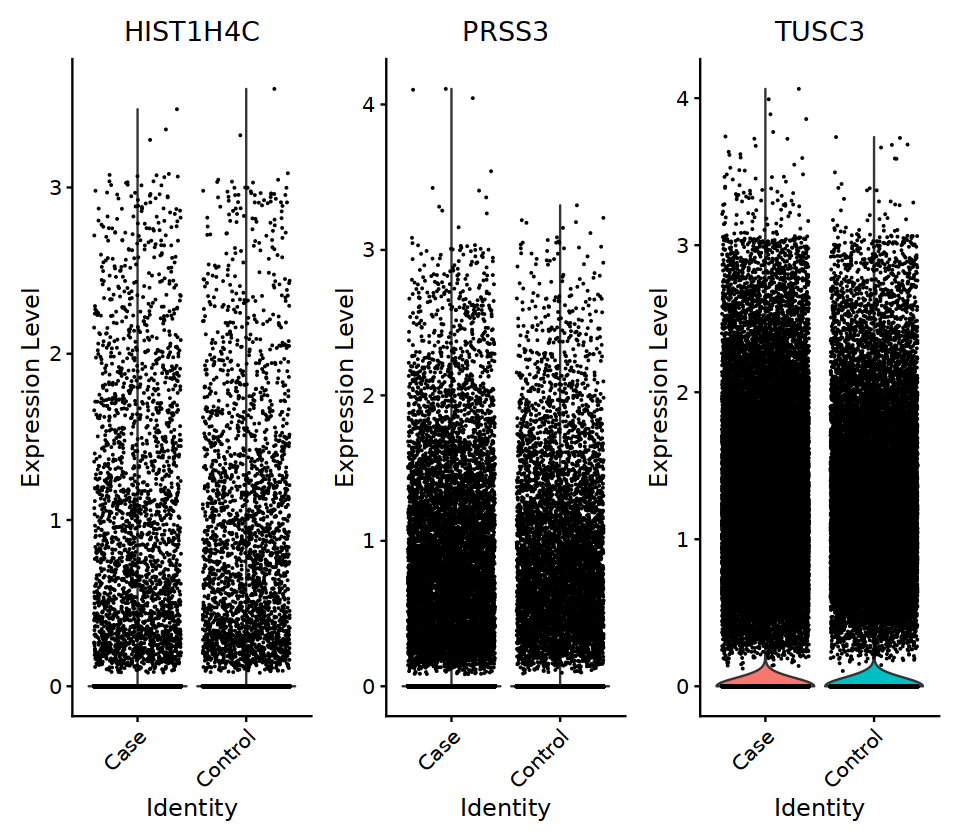

In [10]:
VlnPlot(sce,features = model.gene,raster=FALSE)

In [ ]:
feature = list(model.gene)

sce <- AddModuleScore(sce,
                          features = feature,
                          ctrl = 100,
                          name = 'model_related')

Idents(sce) = 'celltype'

DotPlot(sce,features = 'model_related1')+ggtitle('model_related1')

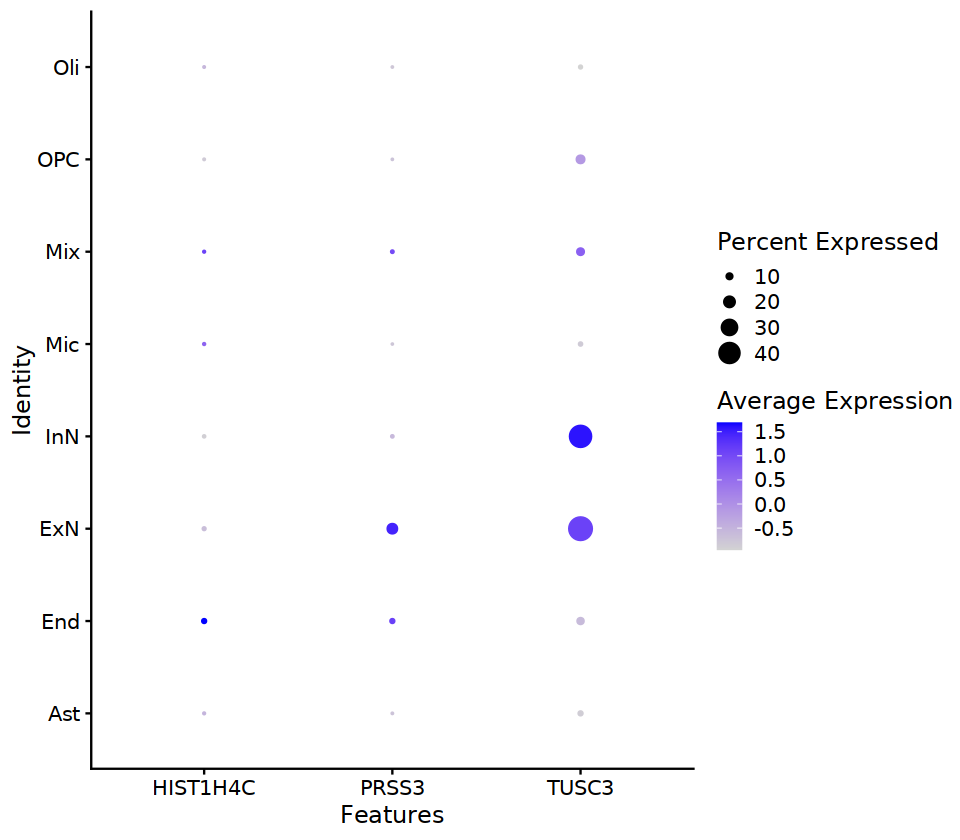

In [17]:
DotPlot(sce,features = model.gene)